# PCA——分析DRL的npz文件

In [1]:
import numpy as np

# 指定要读取的 .npz 文件路径
file_path = './result_multi_env/test_surfrecon/history/0_0.000000_5.822787_2.030269.npz'

# 使用 numpy 加载 .npz 文件
data = np.load(file_path)

# 查看文件中保存的数组名称
print(data.files)

['initial_energy', 'energies', 'actions', 'scaled_positions', 'fingerprints', 'initial_fps', 'minima_energies', 'minima_steps', 'minima_TS', 'minima_highest_energyy', 'segregation', 'force_calls', 'total_force_calls', 'reward', 'episode']


In [2]:
import json
import glob
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ase.io import write, read

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


/root/anaconda3/envs/surfrecon/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [3]:
def sortby(x):
    try:
        return int(x.split('_')[-1].split('.npz')[0])
    except ValueError:
        return float('inf')
    
def get_features(results_list, fps_or_pos):  #从指定的结果文件列表中提取指纹、位置和能量数据
    fps = []
    pos = []
    energies = []
    
    for result in tqdm.tqdm(results_list):
        data = np.load(result)
        #fps（指纹数据）或pos（位置数据）被选择作为特征,根据函数调用时的参数选择不同的特征集。
        if fps_or_pos == 'fps':
            fps.append(data['fingerprints'])
        elif fps_or_pos == 'pos':
            pos.append(data['scaled_positions'])
        elif fps_or_pos == 'both':  #若传入‘both’，那么两种数据都被提取
            fps.append(data['fingerprints'])
            pos.append(data['scaled_positions'])
            
        energies.append(data['energies'])
        #将不同文件的特征进行拼接，形成最终的特征矩阵        
    return np.concatenate(fps), np.concatenate(pos), np.concatenate(energies)

def _PCA(features, energies, n_components=2):
    data = pd.DataFrame(data=features)  #传入代表特征向量的数据集（可以是指纹或位置数据）
    pca = PCA(n_components=n_components) #创建一个PCA对象，并指定降维到2个成分。
    pca.fit(data)  #调用 fit() 方法计算数据的主成分方向
    pca_data = pca.transform(data) #调用 transform() 方法将数据从原始空间投影到主成分空间（即低维空间），返回的即是沿着这些主成分的坐标表示
    pca_data = pd.DataFrame(pca_data[:,:2], columns = ['pc1', 'pc2']) #pc1 和 pc2 分别是降维后数据在第一主成分和第二主成分方向上的坐标
    pca_data['energies'] = energies #能量数据并不是参与PCA计算的直接特征，而是用作可视化的一个辅助指标，这样有助于在PCA结果中识别数据的特定特征或模式。
    
    return pca_data

def plot_PCA_with_kmeans(features, energies, n_clusters, n_components=2, per_atom=False, title=None):
    
    if per_atom:
        fig, axs = plt.subplots(2, 9, figsize=(25,10))
        fig.subplots_adjust(hspace =.5, wspace=.4)
        axs = axs.ravel()
        for i in range(features.shape[1]): # for each free atom,
            pca_data = _PCA(features[:,i], energies, n_components=2)
            pca = axs[i].scatter(pca_data['pc1'], pca_data['pc2'], c = pca_data['energies'], linewidths=10, alpha=1)
            axs[i].set_xlabel('PC 1', fontsize=15)
            axs[i].set_ylabel('PC 2', fontsize=15)
            axs[i].set_title('atom %d' %i)
            cbar = fig.colorbar(pca, ax = axs[i])
            cbar.set_label("ΔE [eV]", fontsize=15)

            # Apply KMeans
            kmeans = KMeans(n_clusters=n_clusters)
            kmeans.fit(pca_data[['pc1', 'pc2']])
            centers = kmeans.cluster_centers_

            # Create a mesh grid for contour
            x_min, x_max = pca_data['pc1'].min() - 1, pca_data['pc1'].max() + 1
            y_min, y_max = pca_data['pc2'].min() - 1, pca_data['pc2'].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                 np.arange(y_min, y_max, 0.01))
            Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            axs[i].contour(xx, yy, Z, colors='black')
            
            # 为聚类中心标记数字
            for j in range(n_clusters):
                axs[i].text(centers[j, 0], centers[j, 1], str(j), fontsize=15, color='red', ha='center', va='center')

            
    else:
        features = features.reshape(len(features), -1)
        pca_data = _PCA(features, energies, n_components=2)

        plt.figure(figsize=(12,10))
        plt.scatter(pca_data['pc1'], pca_data['pc2'], c = pca_data['energies'], linewidths=10, alpha=0.5)
        plt.xlabel('PC 1', fontsize=20)
        plt.ylabel('PC 2', fontsize=20)
        cbar = plt.colorbar()
        cbar.set_label("ΔE [eV]", fontsize=20)
        
        # Add title
        if title:
            plt.title(title, fontsize=24)
        
        # Apply KMeans
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(pca_data[['pc1', 'pc2']])
        centers = kmeans.cluster_centers_

        # Create a mesh grid for contour
        x_min, x_max = pca_data['pc1'].min() - 1, pca_data['pc1'].max() + 1
        y_min, y_max = pca_data['pc2'].min() - 1, pca_data['pc2'].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, colors='black')
        
        # 为聚类中心标记数字
        for j in range(n_clusters):
            plt.text(centers[j, 0], centers[j, 1], str(j), fontsize=20, color='red', ha='center', va='center')
        
    plt.show()
    return


# Load entire results

In [5]:
results_dir = './result_multi_env/test_surfrecon/history/*.npz'

results_list = glob.glob(results_dir)

print('Load %d trajectories' %len(results_list))
results_list.sort(key=sortby)

Load 32 trajectories


# Generate features (fingerprints or positions or both)

In [6]:
fps, pos, energies = get_features(results_list, fps_or_pos='both')
print(np.min(energies), np.max(energies))
#### NOTES
# Saving fingerprints in each episode takes ~1.5 MB
# Saving .traj only takes ~500 kB, but generating fingerprints afterward takes ~10s per episode

100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 21.85it/s]


0.0 2.847363608147493


# Plot PCA for each atom

• PCA using Fingerprints


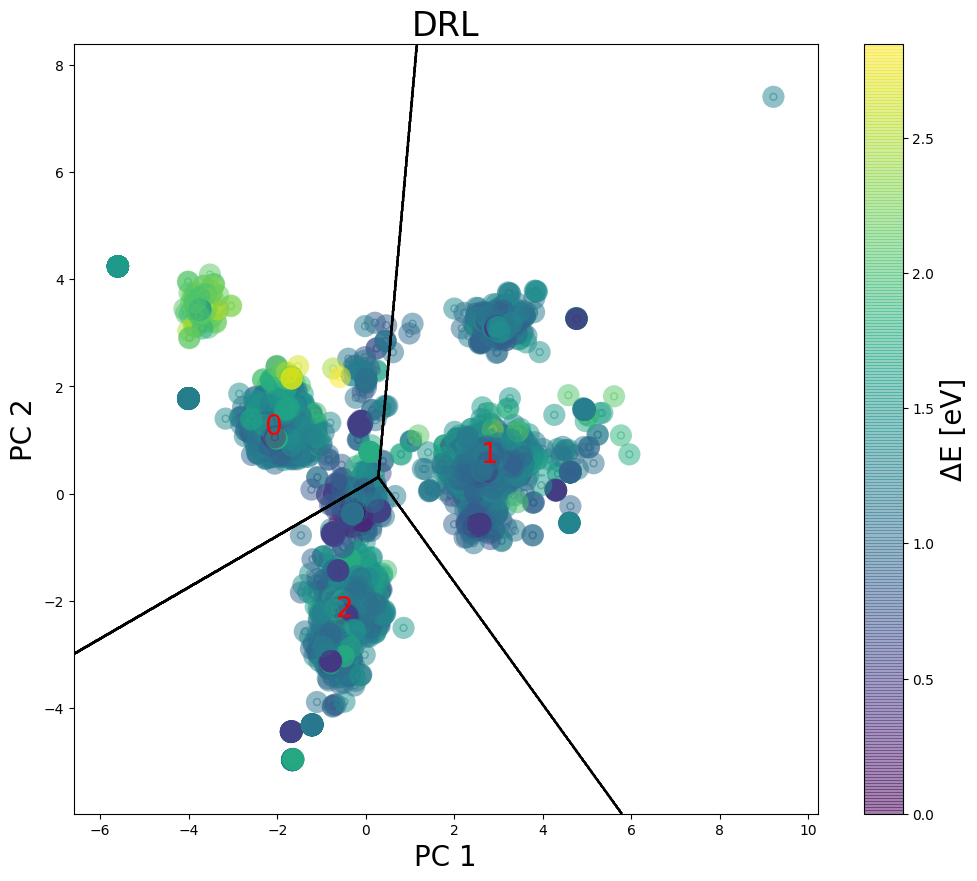

• PCA using Positions


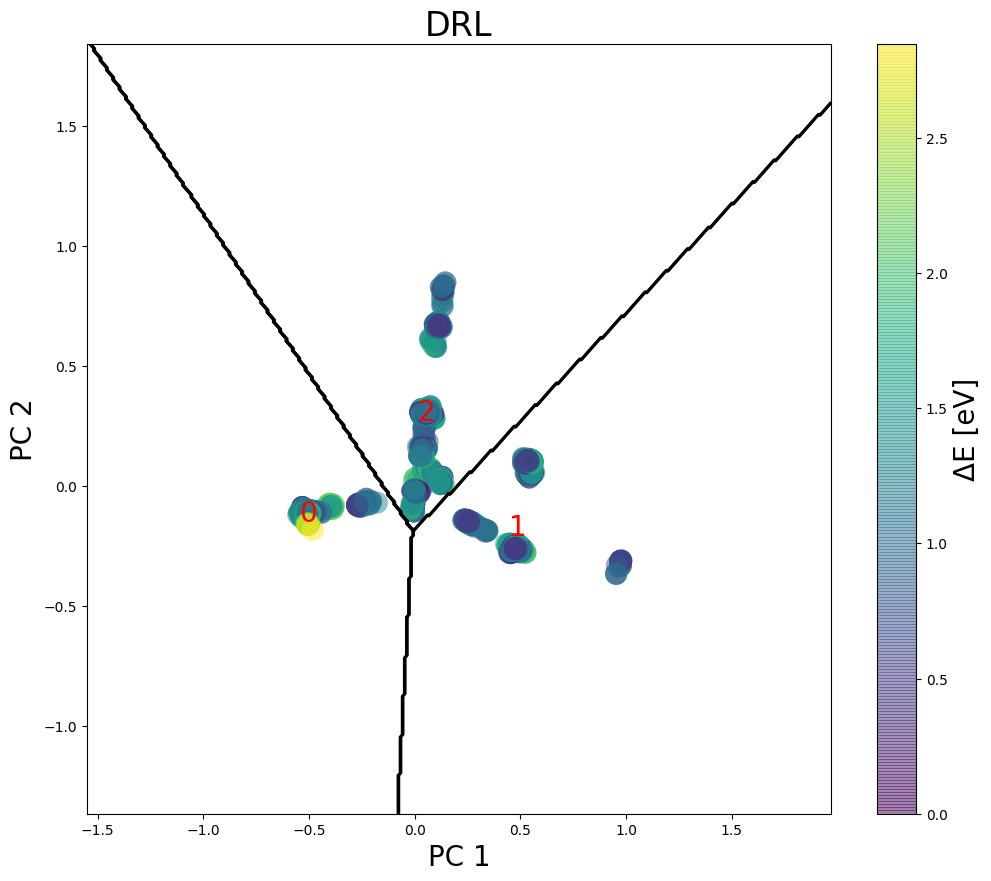


• PCA using Positions for per atom


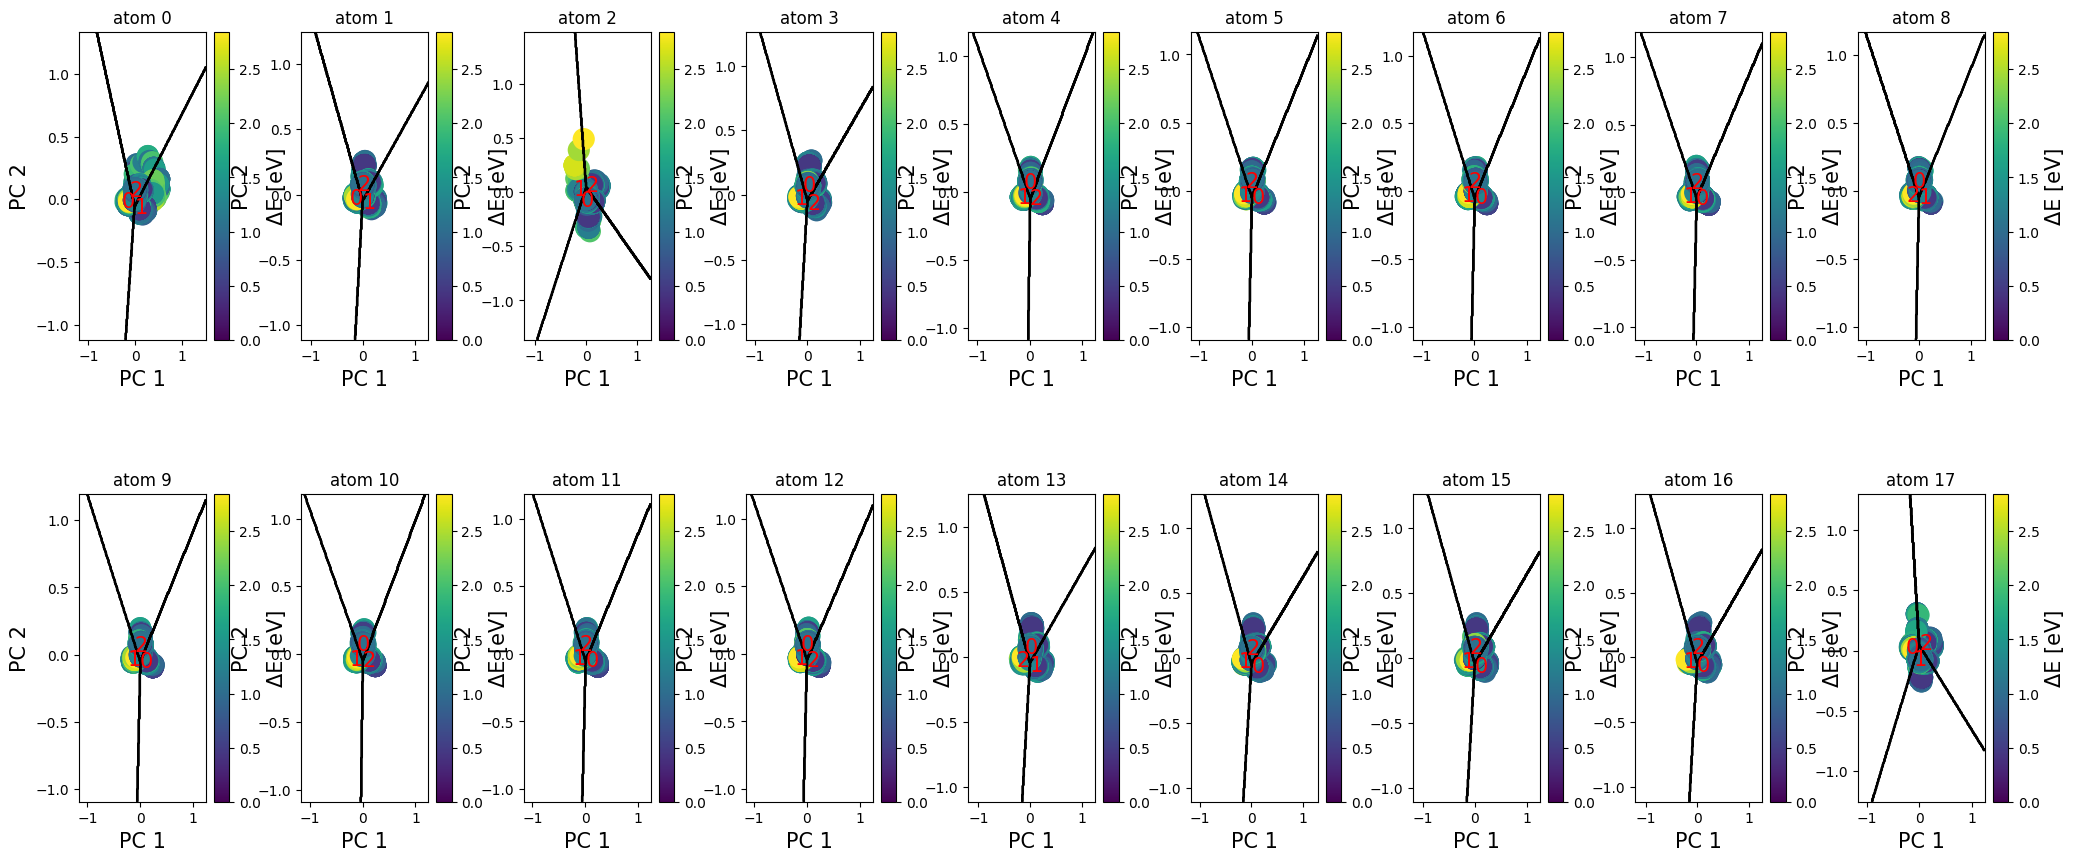

In [7]:
import shutil

%matplotlib inline

print('\u2022 PCA using Fingerprints')
plot_PCA_with_kmeans(fps, energies, n_clusters=3, per_atom=False, title='DRL')

print('\u2022 PCA using Positions')
plot_PCA_with_kmeans(pos, energies, n_clusters=3, per_atom=False, title='DRL')

print('\n\u2022 PCA using Positions for per atom')
plot_PCA_with_kmeans(pos, energies, n_clusters=3, per_atom=True)

#### NOTES
# PCA was performed separately for each atom. So each atom may have different principal components
# Need to find a way for the Featurization at the structure level
# Fingerprints指纹——结构信息   Positions位置——坐标信息
# n_clusters=3表示聚类分了几个组   title='DRL'表示标题
#PC1 是从原始特征数据（比如指纹或位置）中通过PCA方法提取的统计方向，它承载了数据中最大的信息变异，是PCA根据数据的统计属性计算出来的结果。这个方向通常不直接对应数据的具体物理属性，而是从整体数据的变化中提炼的一个新轴。
#通过在PCA图中使用能量作为颜色标识，可以帮助观察者识别数据中是否存在因能量不同而产生的聚类或模式。可以使得在二维PCA投影中更直观地观察到能量与主成分之间的关系，或识别出潜在的异常值（例如具有极高或极低能量的点）。



# PCA——分析MH的traj文件

In [ ]:
import os
import ase.io

def export_frames(input_file, output_dir):
    # 确保输出目录存在，如果不存在则创建它
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 读取 .traj 文件中的所有帧
    frames = ase.io.read(input_file, index=':')

    # 遍历每一帧，并将其分别导出到输出目录
    for i, frame in enumerate(frames):
        # 构造输出文件路径
        frame_file = os.path.join(output_dir, f'structure_{i:04d}.traj')
        # 保存当前帧到输出文件
        ase.io.write(frame_file, frame)
        print(f"Exported frame {i} to {frame_file}")

# 调用函数，传入 .traj 文件的路径和输出目录
input_file = './minima_hopping/minima.traj'
output_dir = './minima_hopping/structure'
export_frames(input_file, output_dir)


In [ ]:
import ase.io

def list_traj_file_arrays(file_path):
    try:
        # 读取.traj文件和其中的数组
        traj = ase.io.read(file_path)
        # 打印Atoms对象的数组标签
        print(f"Arrays in {file_path}: {traj.arrays.keys()}")
    except Exception as e:
        print(f"Could not read file {file_path}: {e}")

# 调用函数，传入.traj文件的路径
list_traj_file_arrays('./minima_hopping/structure/structure_0000.traj')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from ase.io import read
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import glob

def sortby(x):
    try:
        return int(x.split('_')[-1].split('.traj')[0])
    except ValueError:
        return float('inf')

def get_features(traj_files, initial_energy=5.82274):
    pos = []
    energies = []
    for traj_file in tqdm.tqdm(traj_files):
        all_atoms = read(traj_file, index=':')
        for atoms in all_atoms:
            pos.append(atoms.get_positions().flatten())
            energies.append(atoms.get_potential_energy() - initial_energy)
    return np.array(pos), np.array(energies)

def _PCA(features, energies, n_components=2):
    data = pd.DataFrame(data=features)
    pca = PCA(n_components=n_components)
    pca.fit(data)
    pca_data = pca.transform(data)
    pca_data = pd.DataFrame(pca_data[:,:2], columns = ['pc1', 'pc2'])
    pca_data['energies'] = energies
    
    return pca_data

def plot_PCA_with_kmeans(features, energies, n_clusters, n_components=2, per_atom=False, title=None):
    
    if per_atom:
        fig, axs = plt.subplots(2, 9, figsize=(25,10))
        fig.subplots_adjust(hspace =.5, wspace=.4)
        axs = axs.ravel()
        for i in range(features.shape[1]): # for each free atom,
            pca_data = _PCA(features[:,i], energies, n_components=2)
            pca = axs[i].scatter(pca_data['pc1'], pca_data['pc2'], c = pca_data['energies'], linewidths=10, alpha=1)
            axs[i].set_xlabel('PC 1', fontsize=15)
            axs[i].set_ylabel('PC 2', fontsize=15)
            axs[i].set_title('atom %d' %i)
            cbar = fig.colorbar(pca, ax = axs[i])
            cbar.set_label("ΔE [eV]", fontsize=15)

            # Apply KMeans
            kmeans = KMeans(n_clusters=n_clusters)
            kmeans.fit(pca_data[['pc1', 'pc2']])
            centers = kmeans.cluster_centers_

            # Create a mesh grid for contour
            x_min, x_max = pca_data['pc1'].min() - 1, pca_data['pc1'].max() + 1
            y_min, y_max = pca_data['pc2'].min() - 1, pca_data['pc2'].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                 np.arange(y_min, y_max, 0.01))
            Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            axs[i].contour(xx, yy, Z, colors='black')
            
            # 为聚类中心标记数字
            for j in range(n_clusters):
                axs[i].text(centers[j, 0], centers[j, 1], str(j), fontsize=15, color='red', ha='center', va='center')

            
    else:
        features = features.reshape(len(features), -1)
        pca_data = _PCA(features, energies, n_components=2)

        plt.figure(figsize=(12,10))
        plt.scatter(pca_data['pc1'], pca_data['pc2'], c = pca_data['energies'], linewidths=10, alpha=0.5)
        plt.xlabel('PC 1', fontsize=20)
        plt.ylabel('PC 2', fontsize=20)
        cbar = plt.colorbar()
        cbar.set_label("ΔE [eV]", fontsize=20)
        
        # Add title
        if title:
            plt.title(title, fontsize=24)
        
        # Apply KMeans
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(pca_data[['pc1', 'pc2']])
        centers = kmeans.cluster_centers_

        # Create a mesh grid for contour
        x_min, x_max = pca_data['pc1'].min() - 1, pca_data['pc1'].max() + 1
        y_min, y_max = pca_data['pc2'].min() - 1, pca_data['pc2'].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, colors='black')
        
        # 为聚类中心标记数字
        for j in range(n_clusters):
            plt.text(centers[j, 0], centers[j, 1], str(j), fontsize=20, color='red', ha='center', va='center')
        
    plt.show()
    return



/root/anaconda3/envs/catgym/lib/python3.8/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


Load 197 trajectories


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:01<00:00, 165.08it/s]


-0.23351983988439784 0.41355122655250476
• PCA using positions


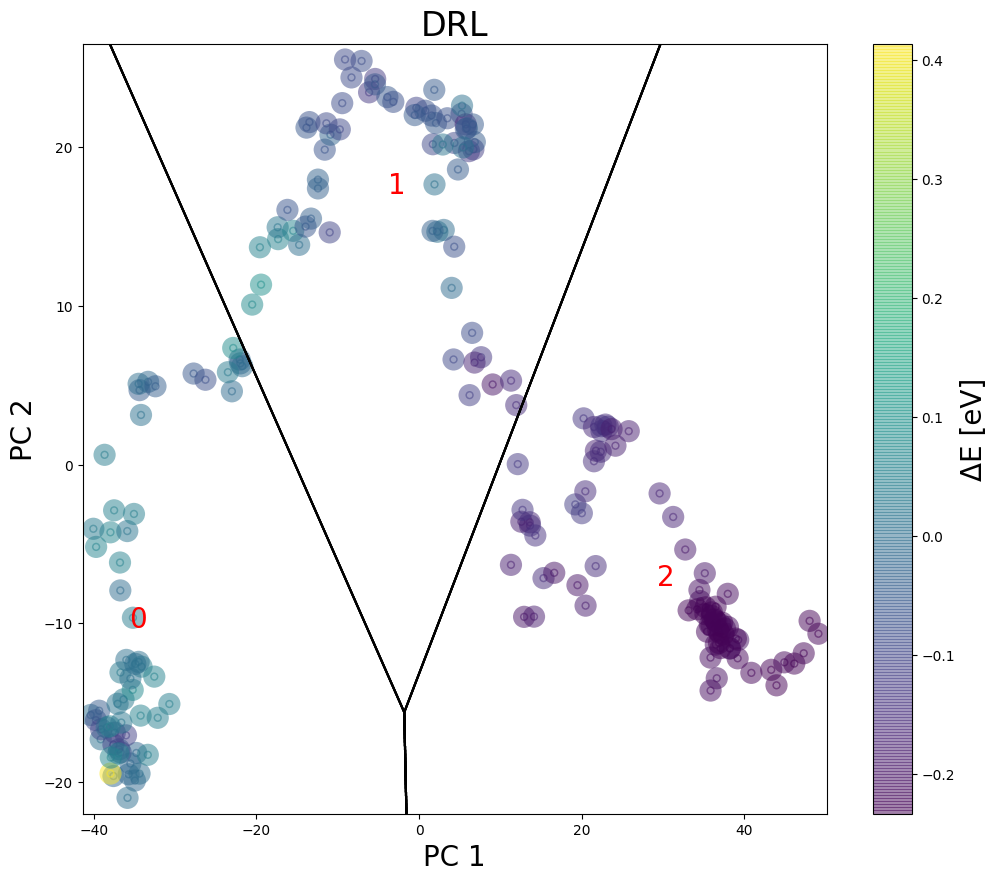

In [2]:
traj_dir = './minima_hopping/structure/*.traj'

traj_files = glob.glob(traj_dir)

print('Load %d trajectories' %len(traj_files))
traj_files.sort(key=sortby)


pos, energies = get_features(traj_files)
print(np.min(energies), np.max(energies))
#### NOTES
# Saving fingerprints in each episode takes ~1.5 MB
# Saving .traj only takes ~500 kB, but generating fingerprints afterward takes ~10s per episode


import shutil

%matplotlib inline

print('\u2022 PCA using positions')
plot_PCA_with_kmeans(pos, energies, n_clusters=3, per_atom=False, title='DRL')

#### NOTES
# PCA was performed separately for each atom. So each atom may have different principal components
# Need to find a way for the Featurization at the structure level
# Fingerprints指纹——结构信息   Positions位置——坐标信息
# n_clusters=3表示聚类分了几个组   title='DRL'表示标题